c:\Users\henri\Desktop\PSC\Data-study\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


📊 Nombre unique de cultures : 50
📊 Nombre unique de municipalités : 37

🔝 Top 10 cultures les plus fréquentes :
Crop
RED SPRING WHEAT      545
ARGENTINE CANOLA      519
BARLEY                505
OATS                  480
ALFALFA/GRASS MIX.    417
FLAX                  394
ALFALFA               378
WINTER WHEAT          272
FIELD PEAS            185
HARD WHITE WHEAT      148
Name: count, dtype: int64

🔝 Top 10 municipalités les plus fréquentes :
Municipality
PORTAGE LA PRAIRIE        327
WESTLAKE-GLADSTONE        259
NORTH CYPRESS-LANGFORD    231
BIFROST-RIVERTON          220
NORFOLK-TREHERNE          215
PRAIRIE VIEW              210
THOMPSON                  193
DAUPHIN                   188
GLENBORO-SOUTH CYPRESS    187
SOURIS-GLENWOOD           185
Name: count, dtype: int64

📈 Moyenne de rendement par culture (Top 10):
                           mean       std  count
Crop                                            
SUGAR BEETS           16.933500       NaN    1.0
PROC POTATOES-IRRIG

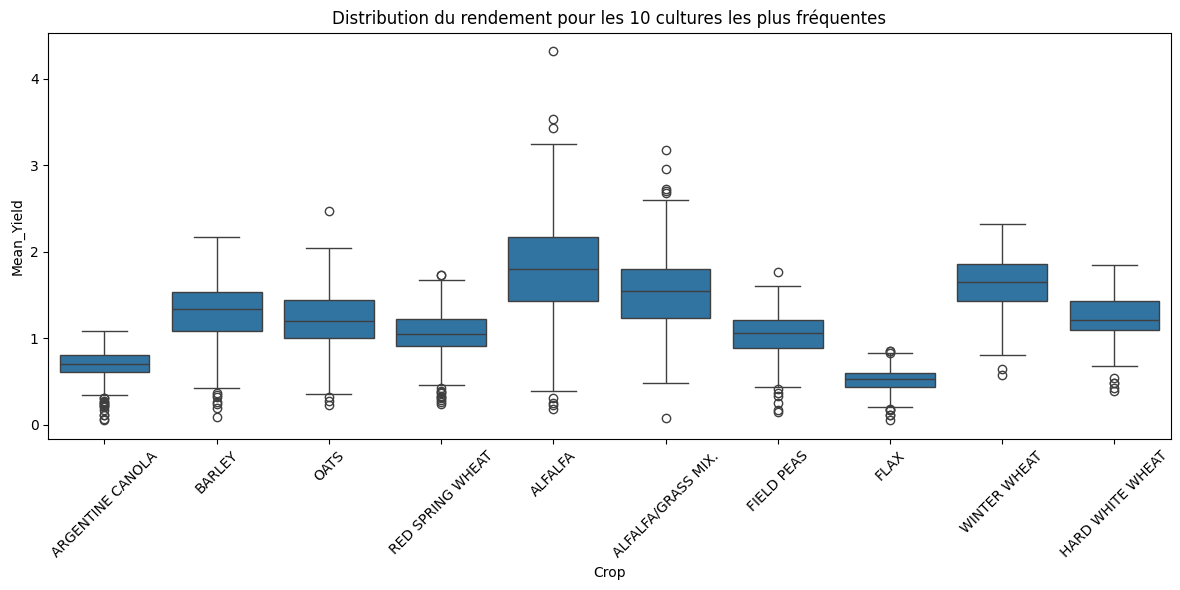

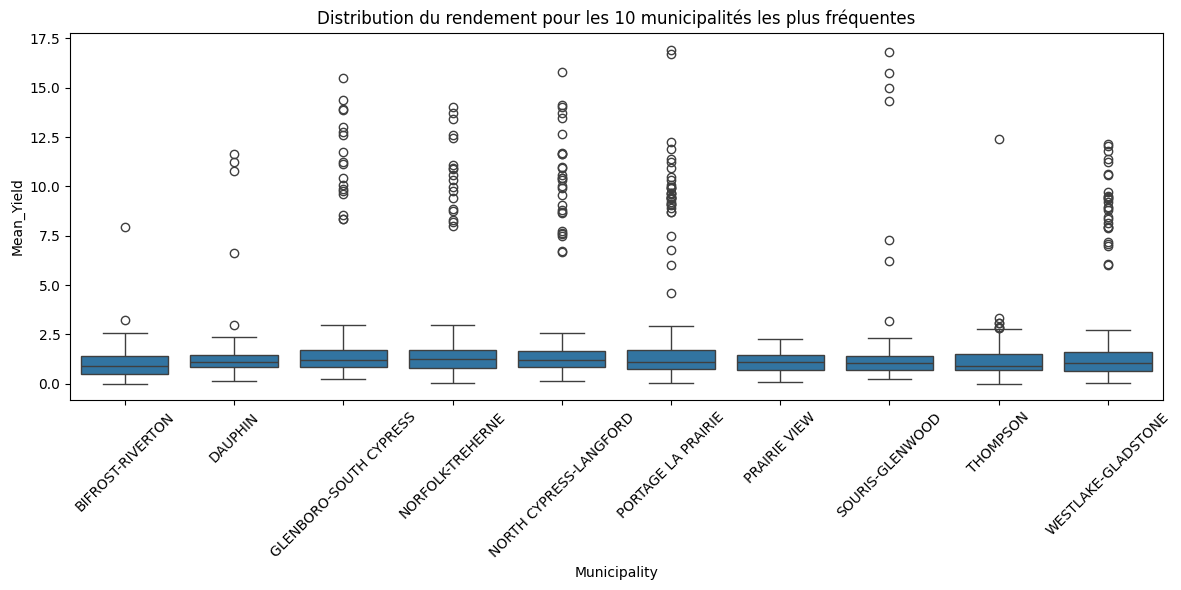

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.metrics import mean_squared_error, r2_score
# === Load the raw data ===
data_path = r"Biweekly_Weather_Per_Year_FIXED.csv"
df = pd.read_csv(data_path)

# Uppercase for consistency
df["Municipality"] = df["Municipality"].str.upper()
df["Crop"] = df["Crop"].str.upper()

# === 1. Unique value counts ===
print("📊 Nombre unique de cultures :", df["Crop"].nunique())
print("📊 Nombre unique de municipalités :", df["Municipality"].nunique())

print("\n🔝 Top 10 cultures les plus fréquentes :")
print(df["Crop"].value_counts().head(10))

print("\n🔝 Top 10 municipalités les plus fréquentes :")
print(df["Municipality"].value_counts().head(10))

# === 2. Mean Yield per Crop and per Municipality ===
crop_yield_stats = df.groupby("Crop")["Mean_Yield"].describe().sort_values("mean", ascending=False)
municipality_yield_stats = df.groupby("Municipality")["Mean_Yield"].describe().sort_values("mean", ascending=False)

# Display a few lines
print("\n📈 Moyenne de rendement par culture (Top 10):")
print(crop_yield_stats[["mean", "std", "count"]].head(10))

print("\n📈 Moyenne de rendement par municipalité (Top 10):")
print(municipality_yield_stats[["mean", "std", "count"]].head(10))

# === 3. Boxplots of Yield Distributions ===
plt.figure(figsize=(12, 6))
top_crops = df["Crop"].value_counts().head(10).index
sns.boxplot(data=df[df["Crop"].isin(top_crops)], x="Crop", y="Mean_Yield")
plt.xticks(rotation=45)
plt.title("Distribution du rendement pour les 10 cultures les plus fréquentes")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
top_munis = df["Municipality"].value_counts().head(10).index
sns.boxplot(data=df[df["Municipality"].isin(top_munis)], x="Municipality", y="Mean_Yield")
plt.xticks(rotation=45)
plt.title("Distribution du rendement pour les 10 municipalités les plus fréquentes")
plt.tight_layout()
plt.show()

In [3]:
# Count unique combinations
num_unique_combos = df.groupby(["Municipality", "Crop"]).ngroups
print(f"\n🔗 Nombre de combinaisons uniques (Municipality + Crop): {num_unique_combos}")

# Optional: count how many times each combination occurs
combo_counts = df.groupby(["Municipality", "Crop"]).size().reset_index(name="count")
print("\n📊 Top 10 combinaisons les plus fréquentes :")
print(combo_counts.sort_values("count", ascending=False).head(30))


🔗 Nombre de combinaisons uniques (Municipality + Crop): 657

📊 Top 10 combinaisons les plus fréquentes :
           Municipality                Crop  count
634           WOODLANDS    RED SPRING WHEAT     16
632           WOODLANDS                OATS     16
21     BIFROST-RIVERTON                FLAX     16
621           WOODLANDS              BARLEY     16
620           WOODLANDS    ARGENTINE CANOLA     16
619           WOODLANDS  ALFALFA/GRASS MIX.     16
618           WOODLANDS             ALFALFA     16
616            WINNIPEG    RED SPRING WHEAT     16
607           WHITEHEAD    RED SPRING WHEAT     16
594           WHITEHEAD              BARLEY     16
593           WHITEHEAD    ARGENTINE CANOLA     16
590  WESTLAKE-GLADSTONE        WINTER WHEAT     16
586  WESTLAKE-GLADSTONE    RED SPRING WHEAT     16
563  WESTLAKE-GLADSTONE              BARLEY     16
562  WESTLAKE-GLADSTONE    ARGENTINE CANOLA     16
561  WESTLAKE-GLADSTONE  ALFALFA/GRASS MIX.     16
552            VICTORIA    

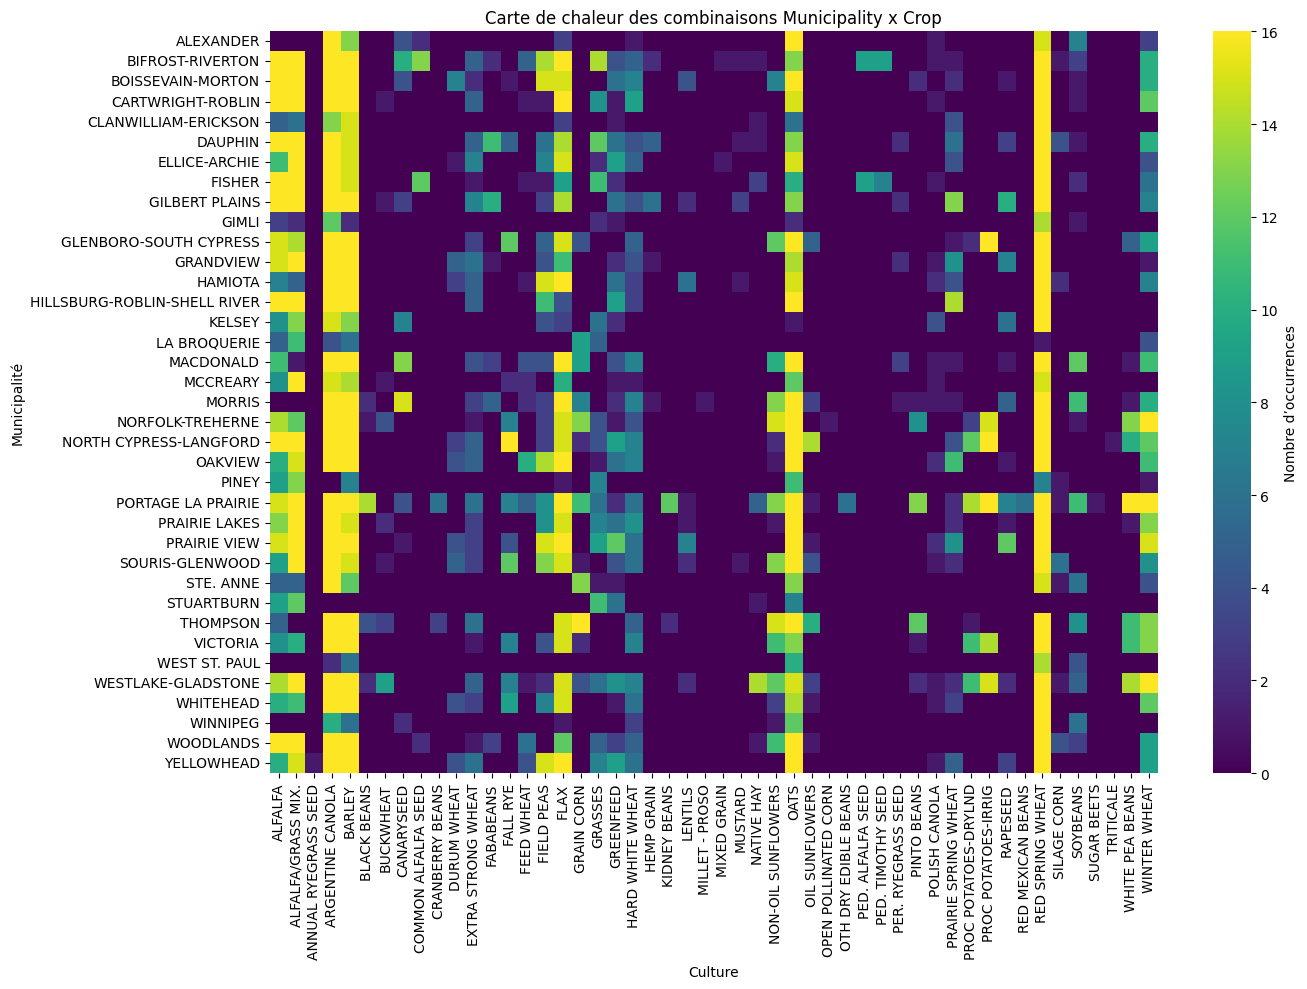

In [4]:
# Pivot to get a heatmap view
pivot_table = df.pivot_table(index="Municipality", columns="Crop", values="Mean_Yield", aggfunc="count", fill_value=0)

plt.figure(figsize=(14, 10))
sns.heatmap(pivot_table, cmap="viridis", cbar_kws={'label': 'Nombre d’occurrences'})
plt.title("Carte de chaleur des combinaisons Municipality x Crop")
plt.xlabel("Culture")
plt.ylabel("Municipalité")
plt.tight_layout()
plt.show()

🔝 Top 3 combinaisons Municipality + Crop :
         Municipality              Crop  count
634         WOODLANDS  RED SPRING WHEAT     16
632         WOODLANDS              OATS     16
21   BIFROST-RIVERTON              FLAX     16


C:\Users\henri\AppData\Local\Temp\ipykernel_2676\308743770.py:22: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\henri\Desktop\PSC\Data-study\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


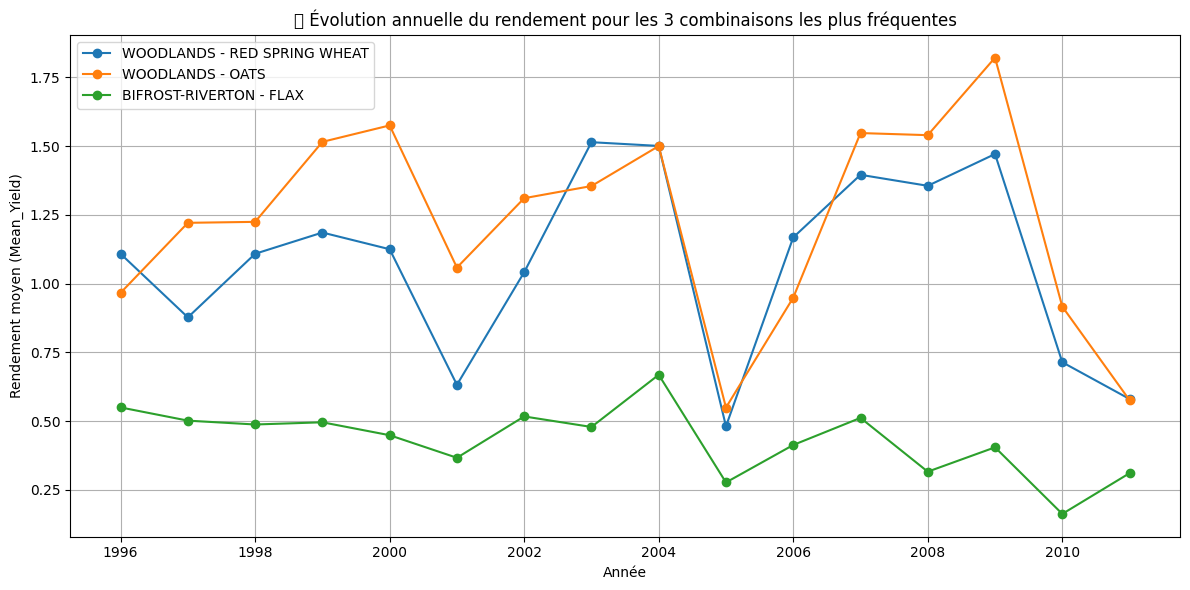

In [5]:
top3_combos = combo_counts.sort_values("count", ascending=False).head(3)

print("🔝 Top 3 combinaisons Municipality + Crop :")
print(top3_combos)

# === Plot Mean_Yield over time for each combo ===
plt.figure(figsize=(12, 6))

for i, row in top3_combos.iterrows():
    muni = row["Municipality"]
    crop = row["Crop"]
    df_subset = df[(df["Municipality"] == muni) & (df["Crop"] == crop)]
    df_grouped = df_subset.groupby("Year")["Mean_Yield"].mean().reset_index()

    plt.plot(df_grouped["Year"], df_grouped["Mean_Yield"], marker='o', label=f"{muni} - {crop}")

plt.title("📈 Évolution annuelle du rendement pour les 3 combinaisons les plus fréquentes")
plt.xlabel("Année")
plt.ylabel("Rendement moyen (Mean_Yield)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()